In [1]:
import glob,pylab,pandas as pd
import pydicom,numpy as np
import random
import json
import time
import copy
import torchvision
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches,patheffects

from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.optim import lr_scheduler
from pathlib import Path




In [2]:
PATH = Path("/data/krf/dataset")
train_bb_df = pd.read_csv(PATH/'stage_1_train_labels.csv')
train_bb_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
train_bb_df['duplicate'] = train_bb_df.duplicated(['patientId'],keep=False)
train_bb_df[train_bb_df['duplicate']].head()

,patientId,x,y,width,height,Target,duplicate
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,True
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,True
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,True
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,True
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,True


In [4]:
detailed_df = pd.read_csv(PATH/'stage_1_detailed_class_info.csv')
# merge two df
class_df = train_bb_df.merge(detailed_df,on="patientId")

csv_df = class_df.filter(['patientId','Target'],)
csv_df = csv_df.set_index('patientId',)
#class_df.head(10)
csv_df.head(10)

,Target
patientId,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
00322d4d-1c29-4943-afc9-b6754be640eb,0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
00436515-870c-4b36-a041-de91049b9ab4,1
00436515-870c-4b36-a041-de91049b9ab4,1
00436515-870c-4b36-a041-de91049b9ab4,1
00436515-870c-4b36-a041-de91049b9ab4,1
00569f44-917d-4c86-a842-81832af98c30,0


In [5]:
class CDataset(Dataset):
    def __init__(self,ds,img_dir,class_df,transform=None,ext=None):
        self.ds = ds
        self.img_dir = img_dir
        self.class_df = class_df
        self.ext = ext or '.dcm'
        self.transform = transforms.Compose(transform) if transform else None
    
    def __len__(self):
        return len(self.ds)
    
    def read_dicom_image(self,loc):
        img_arr = pydicom.read_file(loc.as_posix()).pixel_array
        img_arr = img_arr/img_arr.max()
        img_arr = (255*img_arr).clip(0,255).astype(np.uint8)
        img_arr = Image.fromarray(img_arr).convert('RGB')
        return img_arr
    
    def __getitem__(self,i):
        img = self.read_dicom_image(self.ds[i])
        if self.transform:
            img = self.transform(img)
        patientId = self.ds[i].name.split('.')[0]
        kls = self.class_df[self.class_df['patientId'] == patientId]
        return img,kls.iloc[0].Target

In [6]:
img_dir = PATH/'stage_1_train_images'
#sample = random.sample(list(img_dir.iterdir()),100)
sample = list(img_dir.iterdir())

train,test = train_test_split(sample)

transform = [transforms.Resize(224),transforms.RandomHorizontalFlip(),transforms.ToTensor()]
train_ds = CDataset(train,img_dir,class_df,transform=transform)
test_ds = CDataset(test,img_dir,class_df,transform=transform)

In [7]:
batch_size=32
sz=224
train_dl = DataLoader(train_ds,batch_size = batch_size)
test_dl = DataLoader(test_ds,batch_size=batch_size)

In [8]:
def show_img(im,figsize=None,ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize = figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw,foreground='black'),patheffects.Normal()])
    
def draw_rect(ax,b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:],fill=False,edgecolor='white',lw=2))
    draw_outline(patch,4)

def draw_text(ax,xy,txt,sz=14):
    text = ax.text(*xy,txt,verticalalignment='top',color='white',fontsize=sz,weight='bold')
    draw_outline(text,1)

TypeError: ne() received an invalid combination of arguments - got (str), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mstr[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mstr[0m)


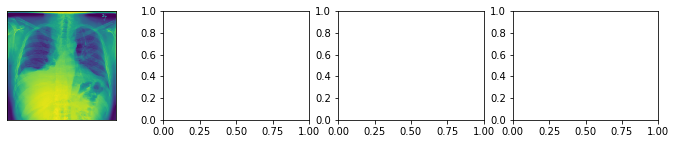

In [9]:
image,klass = next(iter(train_dl))
fig,axes = plt.subplots(1,4,figsize=(12,2))
for i,ax in enumerate(axes.flat):
    image,klass
    ima=image[i][0]
    b = klass[i]
    ax = show_img(ima,ax=ax)
    draw_text(ax,(0,0),b)
    
#plt.tight_layout()

In [13]:
use_gpu = torch.cuda.is_available()
dataloaders = {'train':train_dl,'val':test_dl}

def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            data_loader = dataloaders[phase]
            for data in data_loader:
                #get the inputs
                inputs,labels = data
                #wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(),requires_grad=True)
                    labels = Variable(labels.cuda())
                else:
                    inputs,labels = Variable(inputs),Variable(labels)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                #forward
                outputs = model(inputs)
                _,preds = torch.max(outputs.data,1)
                loss = criterion(outputs,labels)
                
                #backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = float(running_corrects) / len(data_loader.dataset)
            #print(running_corrects,running_loss,len(data_loader.dataset))
            print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
device = torch.cuda.set_device(0)

model_ft = torchvision.models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.cuda()

optimizer_ft = optim.Adam(model_ft.parameters())

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)
since = time.time()

In [16]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=30)
# Save the model checkpoint
torch.save(model_ft.state_dict(), 'resnet.ckpt')

Epoch 0/2
----------


/data/krf/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


trainLoss: 0.4418 Acc: 0.8267
valLoss: 1.5209 Acc: 0.7200

Epoch 1/2
----------
trainLoss: 0.1367 Acc: 0.9467
valLoss: 3.0660 Acc: 0.7200

Epoch 2/2
----------
trainLoss: 0.1150 Acc: 0.9467
valLoss: 3.8490 Acc: 0.7200

Training complete in 0m 39s
Best val Acc: 0.7200
